In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-06-16 19:49:30--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-06-16 19:49:31 (35.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
from fenics import *

In [ ]:
def solve_dar(mu, n, degree):
  # Define the mesh
    mesh = UnitSquareMesh(n, n, 'crossed')

  #Define the FE space
    V = FunctionSpace(mesh, 'P', degree) #degree of polynomial

  #Boundary conditions
    def boundary(x, on_boundary):
      return on_boundary

    g = Constant(0.)
    bc = DirichletBC(V, g, boundary)

  #Problem Defition
    visc = Constant(mu)
    b = Expression(('1', '1'), degree=degree) # vector expression
    sigma = Constant(2.)
    f = Constant(1.)

    u = TrialFunction(V)
    v = TestFunction(V)

    a = visc*dot(grad(u), grad(v))*dx + dot(b, grad(u))*v*dx + sigma*u*v*dx
    L = f * v* dx

    u = Function(V)
    solve(a==L, u, bc)

    return u

In [ ]:
mu = 1e-1
n = 20
degree = 1

u = solve_dar(mu, n, degree)

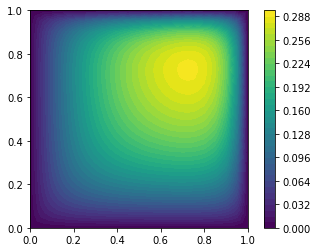

In [ ]:
import matplotlib.pyplot as plt
q = plot(u)
plt.colorbar(q)
# we can not even the see the boundary layer here when the viscosity is too small

In [ ]:
degree = 1
mu = Constant(1e-2)
bx, by = 1.0, 1.0
b = Constant((bx, by))
#b = Expression(('100*x[0]','0*x[1]'),degree=3) # CHECK EXPRESSION OF FENICS!!!!
f = Constant(0)
u_exact = Expression('(exp(bx * (x[0] - 1) / mu) - exp(-bx / mu)) / (1 - exp(-bx/ mu)) + '
'(exp(by * (x[1] - 1) / mu) - exp(-by / mu)) / (1 - exp(-by / mu))',
mu=mu, bx=bx, by=by, degree=2*degree+1)

gD = u_exact

In [ ]:
def solve_dar(n, degree, f, gD):
  # Define the mesh
    mesh = UnitSquareMesh(n, n, 'crossed')

  #Define the FE space
    V = FunctionSpace(mesh, 'CG', degree) #degree of polynomial

  #Boundary conditions
    def boundary(x, on_boundary):
      return on_boundary

    bc = DirichletBC(V, gD, boundary)

  #Problem Defition
    u = TrialFunction(V)
    v = TestFunction(V)

    a = mu*dot(grad(u), grad(v))*dx + dot(b, grad(u))*v*dx
    L = f * v* dx

   # 3.1 Stabilization (streamline diffusion)


    # 4. Solving discrete problem
    u = Function(V)
    solve(a==L, u, bc)

    return u, mesh

L2 error =  0.024337296366772426
H1 error =  4.97097678411887


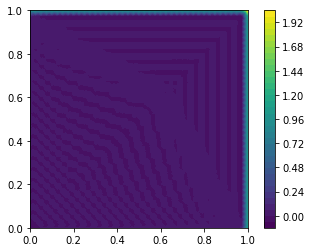

In [ ]:
n = 40

u, mesh = solve_dar(n, degree, f, gD)

errL2 = errornorm(u_exact, u, 'L2')
errH1 = errornorm(u_exact, u, 'H1')
print('L2 error = ', errL2)
print('H1 error = ', errH1)

#ax = plot(mesh)
ax = plot(u)
plt.colorbar(ax)
plt.show()

In [ ]:
def solve_stream_diff(n, degree, f, gD, delta):
  # Define the mesh
    mesh = UnitSquareMesh(n, n, 'crossed')

  #Define the FE space
    V = FunctionSpace(mesh, 'CG', degree) #degree of polynomial

  #Boundary conditions
    def boundary(x, on_boundary):
      return on_boundary

    bc = DirichletBC(V, gD, boundary)

  #Problem Defition
    u = TrialFunction(V)
    v = TestFunction(V)

    a = mu*dot(grad(u), grad(v))*dx + dot(b, grad(u))*v*dx
    L = f * v* dx

   # 3.1 Stabilization (streamline diffusion)
    h = CellDiameter(mesh)
    normb = sqrt(dot(b,b))
    Pe = normb * h / (2 * mu)
    tau = delta * h / (2 * normb) * conditional(Pe/ 3 < 1, Pe/3, 1) # 2. si doğru ise 3.sü 1'e eşitlemece

    c = tau * dot(grad(u), b) * dot(grad(v), b) * dx
    a_stab = a + c

    # 4. Solving discrete problem
    u = Function(V)
    solve(a_stab==L, u, bc)

    return u, mesh

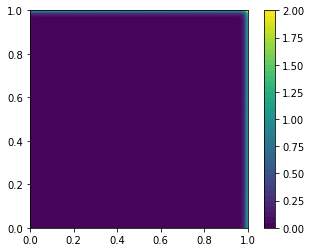

L2 error =  0.007203336680963231
H1 error =  2.795333091964591


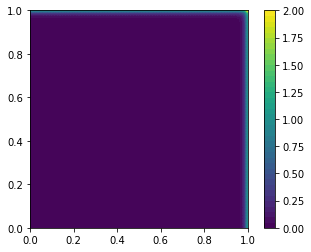

L2 error =  0.011378524389526544
H1 error =  2.7609334935260623


In [ ]:
# Let us test our code for delta=0 (no stabilization)
# and delta=1 (streamline diffusion stabilization)
n = 80
delta = Constant(0.0)
u, mesh = solve_stream_diff(n, degree, f, gD, delta)
#ax = plot(mesh)
ax = plot(u)
plt.colorbar(ax)
plt.show()

errL2 = errornorm(u_exact, u, 'L2')
errH1 = errornorm(u_exact, u, 'H1')
print('L2 error = ', errL2)
print('H1 error = ', errH1)

delta = Constant(1.0)
u, mesh = solve_stream_diff(n, degree, f, gD, delta)
#ax = plot(mesh)
ax = plot(u)
plt.colorbar(ax)
plt.show()

errL2 = errornorm(u_exact, u, 'L2')
errH1 = errornorm(u_exact, u, 'H1')
print('L2 error = ', errL2)
print('H1 error = ', errH1)

In [ ]:
## Strongly consistent method
def solve_dar_sc(n, degree, f, gD, delta, rho):
  # Define the mesh
    mesh = UnitSquareMesh(n, n, 'crossed')

  #Define the FE space
    V = FunctionSpace(mesh, 'CG', degree) #degree of polynomial

  #Boundary conditions
    def boundary(x, on_boundary):
      return on_boundary

    bc = DirichletBC(V, gD, boundary)

  #Problem Defition
    u = TrialFunction(V)
    v = TestFunction(V)

    a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx
    L = f * v * dx

   # 3.1 Stabilization (strongly consistent method )
    h = CellDiameter(mesh)
    normb = sqrt(dot(b,b))
    Pe = normb * h / (2 * mu)
    tau = delta * h / (2 * normb) * conditional(Pe/ 3 < 1, Pe/3, 1) # 2. si doğru ise 3.sü 1'e eşitlemece

    #Residual
    R = lambda w: -mu * div(grad(w)) + dot(b, grad(w))
    P = lambda w: rho * (-mu * div(grad(w)) + dot(b, grad(w)))
    c = tau * R(u) * P(v) * dx
    a_stab = a + c

    # 4. Solving discrete problem
    u = Function(V)
    solve(a_stab==L, u, bc)

    return u, mesh

L2 error =  0.024337296366772426
H1 error =  4.97097678411887


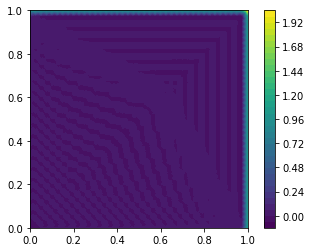

In [ ]:
n = 40
delta = Constant(1.)
#rho = Constant(1.) #SUPG
rho = Constant(0.) #GaLS
u, mesh = solve_dar_sc(n, degree, f, gD, delta, rho)

errL2 = errornorm(u_exact, u, 'L2')
errH1 = errornorm(u_exact, u, 'H1')
print('L2 error = ', errL2)
print('H1 error = ', errH1)

#ax = plot(mesh)
ax = plot(u)
plt.colorbar(ax)
plt.show()